# Mean profiles from CNV files

In [91]:
import unisacsi.Ocean as Oc
#import unisacsi.Meteo as Met
#from unisacsi.MET_model_download import download_MET_model_static_fields, download_MET_model_data
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import gsw
import cmocean as cmo

In [92]:
def compute_mean(CTD, variable, stationnames):
    CTD_i,Z,_,_ = Oc.CTD_to_grid(CTD, stationnames,interp_opt=0)
    df = pd.DataFrame(CTD_i[variable],index=Z
                    ,columns=stationnames
                   )
    df = df[1:]
    df_mean = df.mean(axis=1)
    
    return df, df_mean

In [93]:
def plot_profiles(df, df_mean, ax):
    ax.plot(df, df.index, color='Gray', alpha=.5)
    ax.plot(df_mean, df_mean.index, lw=2)

    ax.invert_yaxis()

In [102]:
def smooth_profile(df_mean, mld, window=5):
    mixed = df_mean[:mld].mean()
    df_smooth = df_mean.rolling(window=window, center=True).mean()
    
    df_smooth[:mld] = mixed
    
    return df_smooth

In [103]:
# path to cnv-files. Should be on the format Sta0001.cnv (Sta followed by four digits)
path_data = '/home/alsjur/PhD/Kurs/AGF-811/data/CTD/PolarsysselCTD/Adventfjorden/221103/'
#path_data = '/home/alsjur/PhD/Kurs/AGF-811/data/CTD/PolarsysselCTD/Adventfjorden/221031/'

In [104]:
# Read in files
CTD = Oc.read_CTD(path_data)
stations = [f'{i}' for i in CTD.keys()]

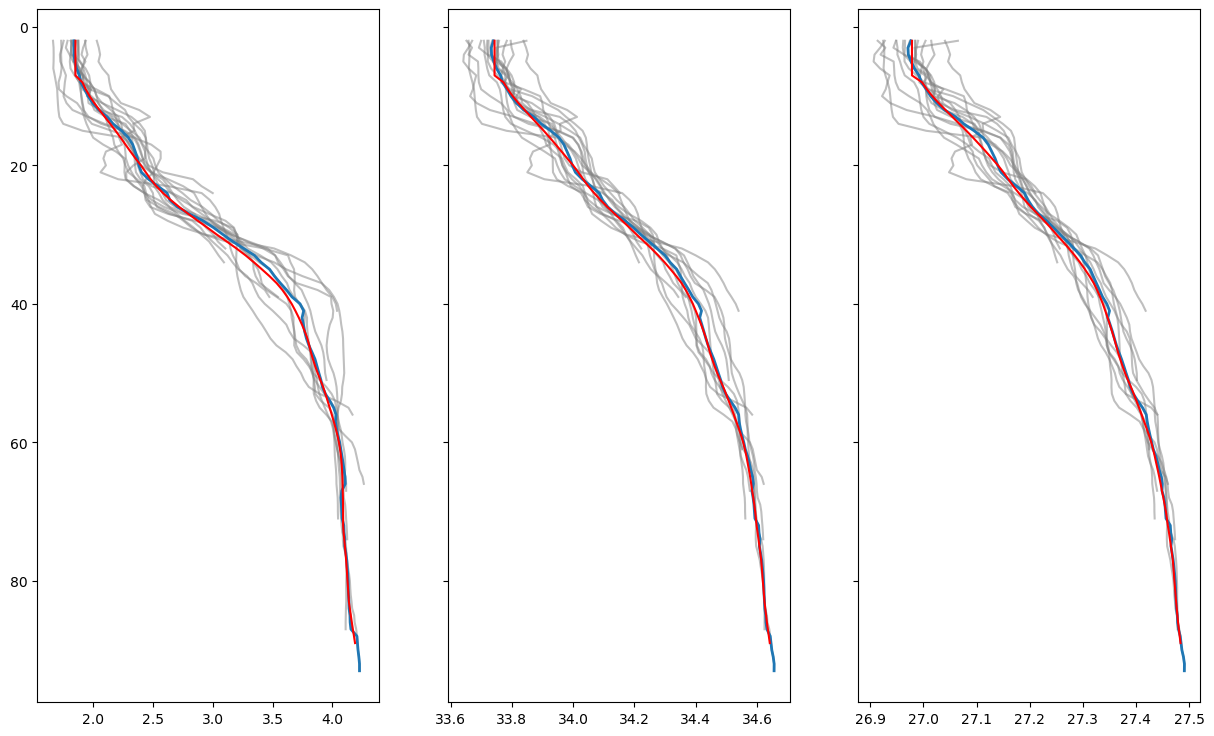

In [105]:
window = 10
mld=7

dfT, dfT_mean = compute_mean(CTD, 'T', stations)
dfS, dfS_mean = compute_mean(CTD, 'S', stations)
dfs, dfs_mean = compute_mean(CTD, 'SIGTH', stations)

dfT_smooth = smooth_profile(dfT_mean, mld, window)
dfS_smooth = smooth_profile(dfS_mean, mld, window)
dfs_smooth = smooth_profile(dfs_mean, mld, window)

fig, [axT, axS, axs] = plt.subplots(1,3, sharey=True, figsize=(15,9))
plot_profiles(dfT, dfT_mean, axT)
plot_profiles(dfS, dfS_mean, axS)
plot_profiles(dfs, dfs_mean, axs)

axT.plot(dfT_smooth, dfT_smooth.index, color='red')
axS.plot(dfS_smooth, dfs_smooth.index, color='red')
axs.plot(dfs_smooth, dfs_smooth.index, color='red')

In [106]:
dfT

,A1,A2,A3,A7,A6,A5,A4,A8,A9,A10,A11,A14,A13,A12,A15
1.989480,1.821276,1.788340,1.874536,1.735219,1.825510,1.941354,1.820603,1.860405,1.880699,1.876310,1.755949,2.032678,1.813534,1.933967,1.667050
2.989484,1.819026,1.774162,1.877785,1.736949,1.817113,1.918198,1.820749,1.851332,1.880596,1.877304,1.741527,2.049447,1.844736,1.940538,1.671717
3.989488,1.822561,1.805517,1.871957,1.734673,1.819106,1.905415,1.813589,1.838888,1.880547,1.881733,1.724480,2.060305,1.850920,1.955129,1.672484
4.989491,1.895199,1.834374,1.855278,1.736985,1.862693,1.937773,1.807370,1.837915,1.887215,1.870664,1.727978,2.046702,1.848922,1.925027,1.671872
5.989495,1.920806,1.860934,1.850359,1.738479,1.885511,1.905055,1.812974,1.893446,1.938656,1.874454,1.753452,2.080948,1.862107,1.910220,1.669607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88.989799,NaN,NaN,4.209214,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89.989802,NaN,NaN,4.213847,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
90.989806,NaN,NaN,4.221040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91.989810,NaN,NaN,4.226243,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [107]:
path_data = '/home/alsjur/PhD/Kurs/AGF-811/data/CTD/PolarsysselCTD/Adventfjorden/221031/'
# Read in files
CTD = Oc.read_CTD(path_data)
stations = [f'{i}' for i in CTD.keys()]

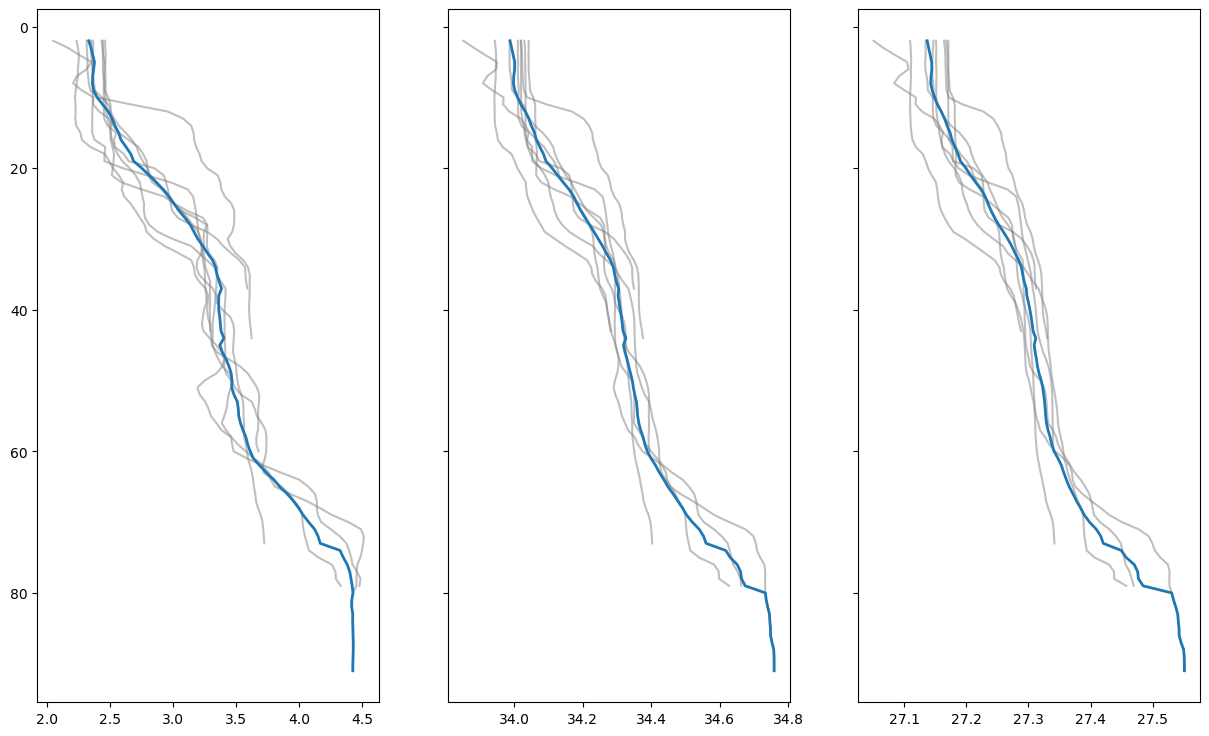

In [110]:
dfT, dfT_mean = compute_mean(CTD, 'T', stations)
dfS, dfS_mean = compute_mean(CTD, 'S', stations)
dfs, dfs_mean = compute_mean(CTD, 'SIGTH', stations)

fig, [axT, axS, axs] = plt.subplots(1,3, sharey=True, figsize=(15,9))
plot_profiles(dfT, dfT_mean, axT)
plot_profiles(dfS, dfS_mean, axS)
plot_profiles(dfs, dfs_mean, axs)

In [111]:
dfT

,A15,A13,A9,322,993,323,324,A2
1.989725,2.314823,2.365033,2.349716,2.235212,2.445002,2.462105,2.432980,2.048388
2.989972,2.316948,2.367941,2.351211,2.245592,2.445165,2.462672,2.440346,2.167311
3.990220,2.319198,2.365287,2.351886,2.254105,2.443633,2.465831,2.447309,2.256473
4.990468,2.322013,2.364835,2.357509,2.251056,2.444539,2.463748,2.459226,2.354691
5.990716,2.320449,2.363346,2.360205,2.245738,2.443418,2.462665,2.455389,2.315073
...,...,...,...,...,...,...,...,...
87.010788,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.429418
88.011036,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.428920
89.011283,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.427727
90.011531,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.426415
